In [1]:
import pickle
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from itertools import product
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 18

In [3]:
# reading in byte-saved variables created by preferences.py that are the same for each run
with open('adjacency.pickle', 'rb') as f:
    # A is the adjacency matrix
    # indexmap maps user_ids to the row indices of A
    # indexmap_back maps row indices of A to user_ids
    # seed is a boolean vector of the initial infected nodes
    A, indexmap, indexmap_back, seed = pickle.load(f)

In [5]:
# adoption times of nodes, index is the adjacency matrix index
original_timeline = pd.read_csv('./vertices_fs.csv')
abm_timelines = pd.read_csv('adoption_times.csv')
timelines = pd.merge(original_timeline,abm_timelines,left_on="id",right_on="node_id")
timelines["new_id"] = timelines["id"].map(indexmap)
timelines.set_index("new_id",inplace=True)
timelines.head()

,id,comm_mem,cityid,month,node_id,ABM1,ABM2
new_id,,,,,,,
24550,72367576,55,78567,78.0,72367576,96.0,55.0
68,64248926,55,379,120.0,64248926,77.0,81.0
23282,70127822,218,46758,94.0,70127822,69.0,65.0
39036,71295318,167,393,84.0,71295318,53.0,71.0
22556,71889448,55,13943,80.0,71889448,49.0,72.0


In [7]:
# calculating the adoption category time bins
percentile_dict = {}
for col in ["month","ABM1","ABM2"]:
    percentile_dict[col] = np.percentile(timelines[col].dropna(),[0,2.5,16,50,84,100])

In [9]:
# getting the adjacency matrix ids of innovators and early adopters
categories = {}
category_names = {
    0: "innovators",
    1: "early_adopters",
    2: "early_majority",
    3: "late_majority",
    4: "laggards"
}


for i in range(5):
    category = category_names[i]
    for col in ["month","ABM1","ABM2"]:
        if category in categories:
            categories[category][col] = np.array(list(map(lambda x: indexmap[x],list(timelines["id"][(timelines[col]>=percentile_dict[col][i])&(timelines[col]<percentile_dict[col][i+1])]))))
        else:
            categories[category] = {}
            categories[category][col] = np.array(list(map(lambda x: indexmap[x],list(timelines["id"][(timelines[col]>=percentile_dict[col][i])&(timelines[col]<percentile_dict[col][i+1])]))))

In [15]:
# checking how many users have been sorted into the different categories
for k in categories:
    for k2 in categories[k]:
        print(k,k2,len(categories[k][k2]))
    print()

innovators month 6428
innovators ABM1 6776
innovators ABM2 6555

early_adopters month 32821
early_adopters ABM1 36279
early_adopters ABM2 34595

early_majority month 94511
early_majority ABM1 91575
early_majority ABM2 90289

late_majority month 93013
late_majority ABM1 91004
late_majority ABM2 92999

laggards month 45101
laggards ABM1 46079
laggards ABM2 47010



In [17]:
# city-city distance matrix
citydist = pd.read_csv("city_dist.csv",sep=";")
citydist["tup"] = citydist.apply(lambda row: (int(row["cityid1"]),int(row["cityid2"])),axis=1)
cd = citydist.fillna(0).set_index("tup")["distkm"].to_dict()

KeyboardInterrupt: 

In [9]:
# creating dicts for faster access by user_id
cities = timelines["cityid"].to_dict()

# creating set from edgelist for fast containment checks
elist_set = set(list(zip(*A.nonzero())))

In [44]:
gravity_res = {}
for col in ["month","ABM1","ABM2"]:
    print(col)
    gravity_dict = {}
    def attr(e,b=10):
        global gravity_dict
        if e[0]<e[1]:
            edge=int(e in elist_set)
            d=cd[(cities[e[0]],cities[e[1]])]
            d_trunc = int(d/b)*b
            if d_trunc in gravity_dict:
                gravity_dict[d_trunc][edge]+=1
            else:
                gravity_dict[d_trunc] = {edge: 1, int(not edge):0}
    for e in tqdm(product(innov_and_early_adopters[col],innov_and_early_adopters[col])):
        attr(e)
    gravity_res[col]=gravity_dict



0it [00:00, ?it/s]

30349it [00:00, 303484.50it/s]



ABM2


76674it [00:00, 338507.20it/s]

119202it [00:00, 360578.47it/s]

153704it [00:00, 355763.04it/s]

207959it [00:00, 396736.58it/s]

254144it [00:00, 414256.99it/s]

298508it [00:00, 422653.89it/s]

343340it [00:00, 430038.70it/s]

389297it [00:00, 438474.22it/s]

448576it [00:01, 475617.29it/s]

512237it [00:01, 514661.68it/s]

566352it [00:01, 522331.63it/s]

619519it [00:01, 510118.33it/s]

671248it [00:01, 492014.81it/s]

721090it [00:01, 489402.68it/s]

771241it [00:01, 492970.41it/s]

826822it [00:01, 510275.39it/s]

898473it [00:01, 558499.15it/s]

955953it [00:01, 558602.91it/s]

1012955it [00:02, 516635.50it/s]

1066044it [00:02, 492120.82it/s]

1116498it [00:02, 492021.33it/s]

1166570it [00:02, 481656.35it/s]

1215393it [00:02, 418848.87it/s]

1259203it [00:02, 368101.26it/s]

1298480it [00:02, 353664.93it/s]

1335694it [00:02, 357061.92it/s]

1381607it [00:03, 382576.02it/s]

1439789it [00:03, 426379.98it/s]

1499706it [00:03, 466761.31it/s]

1556716it [00:03, 493602.59it/s]


18628355it [00:44, 548439.92it/s]

18683931it [00:44, 529899.52it/s]

18746883it [00:44, 556292.62it/s]

18812030it [00:44, 581789.84it/s]

18871075it [00:45, 568438.83it/s]

18947519it [00:45, 615802.94it/s]

19010715it [00:45, 563607.81it/s]

19069068it [00:45, 517563.15it/s]

19122957it [00:45, 498635.42it/s]

19187606it [00:45, 535365.47it/s]

19243054it [00:45, 521980.74it/s]

19296664it [00:45, 520132.55it/s]

19349667it [00:45, 490400.11it/s]

19399750it [00:46, 471830.68it/s]

19447814it [00:46, 451143.28it/s]

19494335it [00:46, 455272.01it/s]

19540957it [00:46, 458498.94it/s]

19591302it [00:46, 471118.04it/s]

19638786it [00:46, 462677.76it/s]

19691055it [00:46, 479169.48it/s]

19739814it [00:46, 481660.31it/s]

19788233it [00:46, 466946.43it/s]

19840000it [00:47, 481084.14it/s]

19888408it [00:47, 432900.75it/s]

19932821it [00:47, 432784.66it/s]

19980345it [00:47, 444702.68it/s]

20027714it [00:47, 453019.21it/s]

20077078it [00:47, 464484.92it/s]

20128333it [00:47, 4

36651587it [01:29, 299476.52it/s]

36696317it [01:29, 332435.16it/s]

36733295it [01:29, 330366.08it/s]

36768949it [01:29, 331034.27it/s]

36806970it [01:29, 344395.93it/s]

36842832it [01:29, 316113.67it/s]

36875894it [01:29, 306355.59it/s]

36914423it [01:29, 326416.64it/s]

36956030it [01:30, 348975.12it/s]

36992144it [01:30, 320530.70it/s]

37025504it [01:30, 302784.12it/s]

37056900it [01:30, 291790.01it/s]

37086947it [01:30, 293380.59it/s]

37129146it [01:30, 322903.09it/s]

37194912it [01:30, 381097.28it/s]

37258633it [01:30, 433348.99it/s]

37308035it [01:30, 448606.71it/s]

37357280it [01:31, 460583.37it/s]

37406487it [01:31, 460320.71it/s]

37455250it [01:31, 468186.64it/s]

37523967it [01:31, 517675.69it/s]

37578458it [01:31, 503694.91it/s]

37630817it [01:31, 506836.10it/s]

37682898it [01:31, 496427.39it/s]

37733567it [01:31, 495840.60it/s]

37783870it [01:31, 462405.21it/s]

37845500it [01:32, 499847.33it/s]

37897027it [01:32, 495710.96it/s]

37947686it [01:32, 4

56196331it [02:13, 538987.17it/s]

56251900it [02:13, 506806.00it/s]

56316293it [02:13, 541391.48it/s]

56372181it [02:13, 536287.91it/s]

56445263it [02:13, 582829.25it/s]

56505593it [02:13, 574982.90it/s]

56564548it [02:14, 562148.62it/s]

56621846it [02:14, 561332.80it/s]

56678738it [02:14, 529791.16it/s]

56732614it [02:14, 500607.21it/s]

56796962it [02:14, 536331.15it/s]

56851981it [02:14, 515184.13it/s]

56904648it [02:14, 488126.59it/s]

56954560it [02:14, 465778.64it/s]

57002985it [02:14, 471169.19it/s]

57050807it [02:15, 418262.63it/s]

57094225it [02:15, 376597.41it/s]

57133785it [02:15, 372512.81it/s]

57172377it [02:15, 337445.92it/s]

57207692it [02:15, 337604.64it/s]

57242552it [02:15, 339493.42it/s]

57277273it [02:15, 330299.22it/s]

57319467it [02:15, 353319.25it/s]

57363391it [02:16, 375345.79it/s]

57401905it [02:16, 351490.18it/s]

57438048it [02:16, 311167.70it/s]

57470712it [02:16, 296408.25it/s]

57508996it [02:16, 317924.43it/s]

57548735it [02:16, 3

72591244it [02:58, 295858.27it/s]

72621856it [02:58, 297984.54it/s]

72652377it [02:58, 295050.05it/s]

72688461it [02:58, 312122.19it/s]

72727171it [02:58, 331377.53it/s]

72768988it [02:58, 353378.23it/s]

72806729it [02:58, 360257.79it/s]

72846283it [02:58, 370161.00it/s]

72883849it [02:58, 355137.33it/s]

72930492it [02:58, 382517.59it/s]

72969867it [02:59, 385816.31it/s]

73009128it [02:59, 366867.47it/s]

73046486it [02:59, 337112.90it/s]

73084436it [02:59, 348795.87it/s]

73122218it [02:59, 357020.32it/s]

73158502it [02:59, 343877.76it/s]

73202678it [02:59, 368361.74it/s]

73248957it [02:59, 392377.99it/s]

73292866it [02:59, 405311.05it/s]

73334221it [03:00, 404803.49it/s]

73375279it [03:00, 381097.98it/s]

73414706it [03:00, 384954.46it/s]

73453693it [03:00, 358663.79it/s]

73490265it [03:00, 334058.74it/s]

73524505it [03:00, 297932.91it/s]

73558452it [03:00, 309285.53it/s]

73602062it [03:00, 338843.63it/s]

73638674it [03:00, 346587.32it/s]

73685057it [03:01, 3

91232158it [03:42, 466231.94it/s]

91280010it [03:42, 414287.93it/s]

91323371it [03:42, 369465.13it/s]

91362573it [03:42, 365199.90it/s]

91403809it [03:43, 378174.65it/s]

91442857it [03:43, 375393.30it/s]

91500174it [03:43, 418737.83it/s]

91549397it [03:43, 438372.15it/s]

91595019it [03:43, 428418.59it/s]

91651974it [03:43, 462821.88it/s]

91701475it [03:43, 472029.19it/s]

91751039it [03:43, 478872.61it/s]

91799816it [03:43, 476996.34it/s]

91853518it [03:44, 493545.16it/s]

91907539it [03:44, 506673.33it/s]

91975963it [03:44, 549448.69it/s]

92032304it [03:44, 539447.86it/s]

92087267it [03:44, 516514.82it/s]

92141738it [03:44, 524659.67it/s]

92194879it [03:44, 525172.14it/s]

92251601it [03:44, 537116.09it/s]

92311328it [03:44, 553843.53it/s]

92367122it [03:44, 466812.83it/s]

92419034it [03:45, 481362.84it/s]

92469120it [03:45, 402117.01it/s]

92512896it [03:45, 381226.57it/s]

92554629it [03:45, 391383.80it/s]

92595740it [03:45, 346846.41it/s]

92637163it [03:45, 3

110170437it [04:26, 335452.33it/s]

110211772it [04:26, 355553.27it/s]

110248043it [04:26, 334761.21it/s]

110287308it [04:26, 350251.39it/s]

110323046it [04:27, 351755.75it/s]

110358722it [04:27, 351012.24it/s]

110394174it [04:27, 336442.30it/s]

110428193it [04:27, 331965.26it/s]

110461665it [04:27, 327909.71it/s]

110510640it [04:27, 363993.99it/s]

110549177it [04:27, 370152.92it/s]

110587191it [04:27, 359149.01it/s]

110623876it [04:27, 353145.37it/s]

110661775it [04:28, 360516.60it/s]

110698258it [04:28, 347786.49it/s]

110744368it [04:28, 375465.72it/s]

110782825it [04:28, 359884.34it/s]

110819589it [04:28, 342182.45it/s]

110860390it [04:28, 359586.84it/s]

110911618it [04:28, 394896.91it/s]

110952677it [04:28, 366009.29it/s]

110990798it [04:28, 360255.93it/s]

111043913it [04:28, 398741.86it/s]

111106308it [04:29, 447159.33it/s]

111154364it [04:29, 384699.09it/s]

111196708it [04:29, 394257.97it/s]

111238904it [04:29, 361907.25it/s]

111277554it [04:29, 335128.3

126324387it [05:10, 472768.07it/s]

126375867it [05:10, 403419.92it/s]

126437822it [05:10, 450574.71it/s]

126487945it [05:10, 439317.04it/s]

126538814it [05:10, 458057.24it/s]

126587353it [05:10, 428983.13it/s]

126632540it [05:10, 415151.88it/s]

126675754it [05:11, 411075.23it/s]

126718060it [05:11, 413199.36it/s]

126763409it [05:11, 424512.94it/s]

126807723it [05:11, 429934.05it/s]

126852972it [05:11, 436459.45it/s]

126896980it [05:11, 429775.68it/s]

126943016it [05:11, 438514.52it/s]

126987105it [05:11, 435920.57it/s]

127037120it [05:11, 453385.60it/s]

127087527it [05:11, 467466.75it/s]

127136688it [05:12, 474456.81it/s]

127184383it [05:12, 474928.35it/s]

127233299it [05:12, 479091.47it/s]

127284658it [05:12, 488943.52it/s]

127333694it [05:12, 375634.78it/s]

127384222it [05:12, 406958.00it/s]

127428528it [05:12, 409630.02it/s]

127487634it [05:12, 451175.78it/s]

127558877it [05:12, 506945.58it/s]

127622876it [05:13, 540661.60it/s]

127680644it [05:13, 474958.7

146649005it [05:53, 374722.57it/s]

146696848it [05:53, 400783.77it/s]

146738851it [05:53, 406369.41it/s]

146780722it [05:53, 403189.54it/s]

146825742it [05:53, 416228.03it/s]

146874499it [05:53, 435335.98it/s]

146926634it [05:53, 458004.46it/s]

146998790it [05:53, 514367.09it/s]

147075173it [05:54, 570237.65it/s]

147139612it [05:54, 590624.02it/s]

147221934it [05:54, 645322.81it/s]

147311700it [05:54, 704754.24it/s]

147386283it [05:54, 715648.87it/s]

147460764it [05:54, 669499.92it/s]

147530359it [05:54, 655014.04it/s]

147602335it [05:54, 673175.15it/s]

147671123it [05:54, 605819.62it/s]

147734010it [05:55, 609219.80it/s]

147796550it [05:55, 611520.20it/s]

147858837it [05:55, 597207.85it/s]

147919426it [05:55, 579307.82it/s]

147978082it [05:55, 552316.01it/s]

148036333it [05:55, 561038.96it/s]

148101078it [05:55, 584438.78it/s]

148160176it [05:55, 565109.25it/s]

148217284it [05:55, 547955.86it/s]

148272611it [05:56, 542466.90it/s]

148327242it [05:56, 523103.9

165602792it [06:36, 286447.22it/s]

165632228it [06:36, 283773.21it/s]

165661165it [06:37, 262494.15it/s]

165688123it [06:37, 259499.93it/s]

165722255it [06:37, 279606.84it/s]

165752054it [06:37, 284876.69it/s]

165781124it [06:37, 281678.46it/s]

165809708it [06:37, 282334.59it/s]

165838233it [06:37, 275407.09it/s]

165866015it [06:37, 274745.75it/s]

165896997it [06:37, 284403.63it/s]

165925643it [06:38, 280024.73it/s]

165954800it [06:38, 283388.28it/s]

165983260it [06:38, 282647.24it/s]

166011610it [06:38, 268343.29it/s]

166048309it [06:38, 291878.89it/s]

166083727it [06:38, 308138.76it/s]

166125475it [06:38, 334411.88it/s]

166160108it [06:38, 333527.00it/s]

166198968it [06:38, 348335.36it/s]

166240864it [06:38, 366887.73it/s]

166278345it [06:39, 369150.57it/s]

166317277it [06:39, 374976.80it/s]

166369036it [06:39, 408764.02it/s]

166411101it [06:39, 386277.59it/s]

166450936it [06:39, 389821.07it/s]

166490688it [06:39, 389762.59it/s]

166530203it [06:39, 333676.3

185956416it [07:20, 301889.55it/s]

185992890it [07:20, 318346.26it/s]

186035050it [07:20, 343589.11it/s]

186076010it [07:20, 361042.88it/s]

186126672it [07:21, 395102.54it/s]

186174824it [07:21, 417584.85it/s]

186218269it [07:21, 415735.37it/s]

186261025it [07:21, 409056.47it/s]

186313945it [07:21, 438952.00it/s]

186375120it [07:21, 479592.27it/s]

186429015it [07:21, 495978.64it/s]

186484840it [07:21, 513148.28it/s]

186537370it [07:21, 445192.16it/s]

186584344it [07:22, 400834.59it/s]

186626983it [07:22, 352223.95it/s]

186672835it [07:22, 378551.02it/s]

186713249it [07:22, 345595.48it/s]

186750156it [07:22, 322628.54it/s]

186790990it [07:22, 344309.64it/s]

186847385it [07:22, 389859.87it/s]

186896362it [07:22, 415272.47it/s]

186940636it [07:23, 377412.61it/s]

186980964it [07:23, 355867.42it/s]

187018615it [07:23, 321127.40it/s]

187055691it [07:23, 334561.02it/s]

187092634it [07:23, 344310.07it/s]

187128262it [07:23, 346846.10it/s]

187167509it [07:23, 359376.5

204952196it [08:03, 595146.35it/s]

205015427it [08:04, 592261.43it/s]

205077258it [08:04, 514637.23it/s]

205132363it [08:04, 447483.69it/s]

205181228it [08:04, 387319.86it/s]

205224278it [08:04, 345636.12it/s]

205262701it [08:04, 321484.69it/s]

205297890it [08:05, 304163.85it/s]

205330628it [08:05, 292782.01it/s]

205361623it [08:05, 291733.15it/s]

205391999it [08:05, 281614.42it/s]

205421078it [08:05, 278420.18it/s]

205469936it [08:05, 319670.95it/s]

205544575it [08:05, 385849.08it/s]

205606000it [08:05, 434293.09it/s]

205657057it [08:05, 414955.24it/s]

205704074it [08:05, 419579.12it/s]

205749909it [08:06, 430352.66it/s]

205823545it [08:06, 491644.79it/s]

205890684it [08:06, 534570.99it/s]

205948739it [08:06, 530053.68it/s]

206004972it [08:06, 515698.67it/s]

206058886it [08:06, 510575.91it/s]

206149328it [08:06, 587299.22it/s]

206239262it [08:06, 655533.13it/s]

206321280it [08:06, 697540.80it/s]

206396146it [08:07, 651605.18it/s]

206465497it [08:07, 515473.5

226799914it [08:47, 457430.84it/s]

226864622it [08:47, 501524.36it/s]

226916705it [08:47, 481683.96it/s]

226966393it [08:48, 471842.61it/s]

227029195it [08:48, 509881.43it/s]

227081841it [08:48, 498578.82it/s]

227132915it [08:48, 501573.48it/s]

227193414it [08:48, 528684.87it/s]

227247273it [08:48, 525522.65it/s]

227302217it [08:48, 532475.00it/s]

227355975it [08:48, 501504.29it/s]

227406853it [08:48, 477157.81it/s]

227471737it [08:48, 518300.10it/s]

227525133it [08:49, 521955.11it/s]

227578431it [08:49, 495336.32it/s]

227652024it [08:49, 549199.42it/s]

227709514it [08:49, 549312.12it/s]

227766244it [08:49, 553510.99it/s]

227822862it [08:49, 540679.47it/s]

227877883it [08:49, 505103.49it/s]

227929534it [08:49, 490058.42it/s]

227979436it [08:49, 472279.27it/s]

228027430it [08:50, 455275.99it/s]

228073626it [08:50, 443528.66it/s]

228133840it [08:50, 481584.11it/s]

228183325it [08:50, 465570.65it/s]

228244638it [08:50, 501798.85it/s]

228298095it [08:50, 511197.0

246916053it [09:31, 330310.53it/s]

246949786it [09:31, 315664.00it/s]

246981981it [09:31, 305739.04it/s]

247013063it [09:31, 299386.37it/s]

247044347it [09:31, 303298.62it/s]

247078066it [09:31, 312727.48it/s]

247114170it [09:31, 325805.43it/s]

247147082it [09:31, 318386.49it/s]

247179190it [09:32, 298716.95it/s]

247211559it [09:32, 305791.86it/s]

247243066it [09:32, 308511.45it/s]

247274166it [09:32, 298246.13it/s]

247304239it [09:32, 294528.45it/s]

247333876it [09:32, 294439.69it/s]

247363449it [09:32, 283656.53it/s]

247391990it [09:32, 280919.15it/s]

247420952it [09:32, 283473.50it/s]

247451631it [09:32, 290086.92it/s]

247480745it [09:33, 260881.87it/s]

247515619it [09:33, 282210.86it/s]

247560355it [09:33, 317357.57it/s]

247614568it [09:33, 362437.63it/s]

247656127it [09:33, 376898.17it/s]

247710215it [09:33, 414605.28it/s]

247765491it [09:33, 448211.71it/s]

247815691it [09:33, 463097.22it/s]

247864178it [09:33, 468505.54it/s]

247912844it [09:34, 473805.5

266146635it [10:15, 683808.56it/s]

266217083it [10:15, 636337.77it/s]

266282825it [10:15, 622306.93it/s]

266348814it [10:15, 633122.10it/s]

266413253it [10:15, 584638.14it/s]

266473696it [10:15, 590437.59it/s]

266535068it [10:15, 597232.37it/s]

266595567it [10:15, 580078.37it/s]

266654226it [10:15, 577241.43it/s]

266712409it [10:16, 553796.32it/s]

266768313it [10:16, 530082.01it/s]

266821904it [10:16, 527959.61it/s]

266875110it [10:16, 509611.58it/s]

266926496it [10:16, 446906.73it/s]

266972883it [10:16, 412036.42it/s]

267032907it [10:16, 454815.44it/s]

267094622it [10:16, 493777.24it/s]

267146776it [10:16, 473357.02it/s]

267196235it [10:17, 462966.50it/s]

267244069it [10:17, 416095.69it/s]

267287650it [10:17, 406217.73it/s]

267329704it [10:17, 363019.09it/s]

267367867it [10:17, 334192.63it/s]

267403040it [10:17, 320136.73it/s]

267436407it [10:17, 322311.45it/s]

267469589it [10:17, 303538.78it/s]

267505512it [10:18, 318342.47it/s]

267544410it [10:18, 336683.5

287791363it [10:58, 387884.00it/s]

287831727it [10:58, 383880.48it/s]

287871227it [10:59, 366899.36it/s]

287908855it [10:59, 326272.33it/s]

287959467it [10:59, 365202.32it/s]

288005179it [10:59, 388646.21it/s]

288046239it [10:59, 357711.50it/s]

288091306it [10:59, 381306.71it/s]

288145004it [10:59, 417627.21it/s]

288196395it [10:59, 442495.66it/s]

288243798it [10:59, 451506.27it/s]

288290416it [11:00, 447749.03it/s]

288343237it [11:00, 469190.04it/s]

288394055it [11:00, 480243.82it/s]

288442840it [11:00, 420988.98it/s]

288496389it [11:00, 449840.92it/s]

288543222it [11:00, 393662.03it/s]

288585150it [11:00, 367470.05it/s]

288628316it [11:00, 384626.31it/s]

288668491it [11:01, 356760.74it/s]

288705806it [11:01, 361523.43it/s]

288743095it [11:01, 325839.29it/s]

288777143it [11:01, 323918.82it/s]

288810562it [11:01, 292716.02it/s]

288844143it [11:01, 304435.08it/s]

288880216it [11:01, 319386.89it/s]

288919995it [11:01, 339457.18it/s]

288955522it [11:01, 344048.2

308165532it [11:42, 452370.21it/s]

308217629it [11:42, 470972.58it/s]

308267286it [11:42, 453688.96it/s]

308314583it [11:43, 438989.84it/s]

308389140it [11:43, 500763.88it/s]

308443254it [11:43, 504137.30it/s]

308503223it [11:43, 529444.47it/s]

308571446it [11:43, 567576.64it/s]

308630597it [11:43, 551793.30it/s]

308700139it [11:43, 588239.93it/s]

308760867it [11:43, 578201.99it/s]

308842961it [11:43, 634482.90it/s]

308909023it [11:44, 630045.50it/s]

308973865it [11:44, 607533.39it/s]

309036078it [11:44, 514079.26it/s]

309090976it [11:44, 449951.93it/s]

309139860it [11:44, 422838.34it/s]

309185200it [11:44, 386684.74it/s]

309226610it [11:44, 367006.91it/s]

309265759it [11:44, 374019.91it/s]

309304683it [11:45, 338543.74it/s]

309340246it [11:45, 314604.74it/s]

309377544it [11:45, 330103.62it/s]

309430945it [11:45, 372808.68it/s]

309479166it [11:45, 400035.97it/s]

309539436it [11:45, 444917.17it/s]

309587254it [11:45, 417527.91it/s]

309631679it [11:45, 375114.7

327229944it [12:27, 488840.64it/s]

327281697it [12:27, 497091.22it/s]

327333176it [12:27, 491731.01it/s]

327383601it [12:27, 494899.76it/s]

327448125it [12:27, 532092.70it/s]

327512540it [12:27, 561390.60it/s]

327581526it [12:27, 594609.45it/s]

327642512it [12:27, 590841.37it/s]

327702669it [12:27, 592666.44it/s]

327781200it [12:27, 639746.18it/s]

327850117it [12:28, 653800.83it/s]

327916692it [12:28, 643247.51it/s]

327997975it [12:28, 686194.39it/s]

328067999it [12:28, 621025.91it/s]

328132267it [12:28, 620321.58it/s]

328195816it [12:28, 618244.72it/s]

328258704it [12:28, 582415.50it/s]

328318117it [12:28, 579782.76it/s]

328376918it [12:28, 536502.88it/s]

328453490it [12:29, 589436.16it/s]

328514869it [12:29, 589033.22it/s]

328575478it [12:29, 591130.48it/s]

328635901it [12:29, 594999.22it/s]

328696244it [12:29, 584184.33it/s]

328766541it [12:29, 615378.04it/s]

328828967it [12:29, 576050.35it/s]

328895271it [12:29, 594669.77it/s]

328955683it [12:29, 560624.5

348094158it [13:10, 431633.58it/s]

348139062it [13:11, 385899.66it/s]

348179777it [13:11, 375491.71it/s]

348220457it [13:11, 384363.22it/s]

348263050it [13:11, 395952.90it/s]

348315912it [13:11, 428191.57it/s]

348360106it [13:11, 387540.55it/s]

348400560it [13:11, 354668.10it/s]

348437760it [13:11, 354089.82it/s]

348474382it [13:11, 356151.85it/s]

348524670it [13:12, 390317.04it/s]

348565284it [13:12, 390490.86it/s]

348605441it [13:12, 372470.70it/s]

348651470it [13:12, 395082.20it/s]

348692017it [13:12, 373623.06it/s]

348730348it [13:12, 363658.61it/s]

348767450it [13:12, 329520.11it/s]

348801531it [13:12, 319601.59it/s]

348842314it [13:12, 341782.91it/s]

348877520it [13:13, 330561.29it/s]

348926490it [13:13, 366269.15it/s]

348969293it [13:13, 382838.96it/s]

349009007it [13:13, 357547.41it/s]

349046101it [13:13, 320117.87it/s]

349083012it [13:13, 333390.81it/s]

349117664it [13:13, 327592.60it/s]

349157685it [13:13, 346449.45it/s]

349207501it [13:13, 381283.6

368580014it [13:54, 586623.10it/s]

368639448it [13:54, 572809.25it/s]

368699525it [13:54, 580918.08it/s]

368758073it [13:54, 525453.69it/s]

368811949it [13:55, 502208.84it/s]

368863319it [13:55, 501070.63it/s]

368914231it [13:55, 428910.04it/s]

368964660it [13:55, 449046.00it/s]

369017235it [13:55, 469599.41it/s]

369065780it [13:55, 472598.78it/s]

369114154it [13:55, 443380.36it/s]

369166506it [13:55, 464720.98it/s]

369214052it [13:55, 461728.29it/s]

369273655it [13:56, 495202.33it/s]

369328262it [13:56, 509437.39it/s]

369380156it [13:56, 475175.72it/s]

369434921it [13:56, 494818.19it/s]

369495721it [13:56, 524086.28it/s]

369557982it [13:56, 550203.53it/s]

369614165it [13:56, 540356.78it/s]

369684193it [13:56, 580099.19it/s]

369743624it [13:56, 535157.45it/s]

369815124it [13:57, 578832.24it/s]

369885692it [13:57, 611824.78it/s]

369956450it [13:57, 637714.28it/s]

370021940it [13:57, 605643.79it/s]

370084044it [13:57, 572636.24it/s]

370142758it [13:57, 530705.4

390156114it [14:38, 537360.56it/s]

390217205it [14:38, 557495.97it/s]

390273774it [14:39, 481914.33it/s]

390324356it [14:39, 471794.79it/s]

390379172it [14:39, 492371.04it/s]

390429847it [14:39, 465166.76it/s]

390477681it [14:39, 454408.90it/s]

390524099it [14:39, 456458.36it/s]

390591040it [14:39, 504615.47it/s]

390656790it [14:39, 542454.19it/s]

390716927it [14:39, 558879.52it/s]

390774508it [14:40, 518394.02it/s]

390828118it [14:40, 467567.66it/s]

390880777it [14:40, 483833.09it/s]

390930834it [14:40, 446934.66it/s]

390977257it [14:40, 414664.86it/s]

391020399it [14:40, 376396.53it/s]

391059890it [14:40, 368296.68it/s]

391112703it [14:40, 405073.61it/s]

391156731it [14:40, 415026.27it/s]

391207792it [14:41, 439719.89it/s]

391253210it [14:41, 424299.69it/s]

391301237it [14:41, 439668.62it/s]

391377159it [14:41, 503205.76it/s]

391431365it [14:41, 505976.79it/s]

391484686it [14:41, 501685.20it/s]

391566034it [14:41, 566865.37it/s]

391641509it [14:41, 612615.5

410199385it [15:22, 395214.44it/s]

410254460it [15:22, 431795.59it/s]

410300825it [15:22, 427684.83it/s]

410345833it [15:22, 433577.51it/s]

410398072it [15:22, 456879.27it/s]

410445205it [15:22, 410714.57it/s]

410488169it [15:23, 401692.49it/s]

410535001it [15:23, 419599.35it/s]

410578127it [15:23, 418452.10it/s]

410620789it [15:23, 367839.96it/s]

410670897it [15:23, 399724.90it/s]

410715959it [15:23, 413743.24it/s]

410767880it [15:23, 440591.71it/s]

410816093it [15:23, 452280.62it/s]

410862477it [15:23, 437342.52it/s]

410908857it [15:24, 444955.28it/s]

410972163it [15:24, 488500.14it/s]

411022773it [15:24, 479623.63it/s]

411087099it [15:24, 519248.69it/s]

411163369it [15:24, 574235.02it/s]

411260117it [15:24, 653980.24it/s]

411331500it [15:24, 653662.44it/s]

411401056it [15:24, 588293.40it/s]

411464055it [15:24, 577261.49it/s]

411524746it [15:24, 573557.95it/s]

411584183it [15:25, 536999.86it/s]

411644981it [15:25, 556490.30it/s]

411703161it [15:25, 563847.5

434114261it [16:05, 377023.98it/s]

434153171it [16:05, 362282.84it/s]

434194821it [16:05, 377004.04it/s]

434238486it [16:05, 393113.32it/s]

434278559it [16:05, 374672.17it/s]

434316741it [16:05, 358088.20it/s]

434362969it [16:06, 384055.07it/s]

434402363it [16:06, 373144.97it/s]

434454602it [16:06, 408124.34it/s]

434497213it [16:06, 413355.53it/s]

434539623it [16:06, 397795.75it/s]

434585396it [16:06, 414059.67it/s]

434646903it [16:06, 459067.02it/s]

434694889it [16:06, 438371.23it/s]

434752094it [16:06, 471418.64it/s]

434802471it [16:06, 480677.03it/s]

434870189it [16:07, 526509.49it/s]

434925095it [16:07, 525079.62it/s]

434989068it [16:07, 554912.01it/s]

435054370it [16:07, 581099.10it/s]

435116758it [16:07, 593303.33it/s]

435177144it [16:07, 581358.67it/s]

435236072it [16:07, 575305.97it/s]

435294172it [16:07, 524424.44it/s]

435347883it [16:07, 518614.41it/s]

435400648it [16:08, 518900.75it/s]

435453170it [16:08, 496951.95it/s]

435515673it [16:08, 529501.7

456308794it [16:48, 450644.22it/s]

456355161it [16:48, 451636.32it/s]

456403884it [16:48, 461755.01it/s]

456450754it [16:48, 449341.10it/s]

456496248it [16:49, 423982.69it/s]

456539333it [16:49, 369472.97it/s]

456578019it [16:49, 348643.00it/s]

456617517it [16:49, 361359.57it/s]

456661065it [16:49, 380803.49it/s]

456705459it [16:49, 397774.11it/s]

456786805it [16:49, 469794.55it/s]

456869515it [16:49, 539744.02it/s]

456942526it [16:49, 585544.68it/s]

457007726it [16:50, 572960.88it/s]

457069734it [16:50, 532745.27it/s]

457126873it [16:50, 530840.49it/s]

457182664it [16:50, 524078.42it/s]

457236986it [16:50, 500588.61it/s]

457309769it [16:50, 552321.54it/s]

457368388it [16:50, 562063.28it/s]

457426553it [16:50, 531773.69it/s]

457494916it [16:50, 569738.48it/s]

457577069it [16:51, 627425.91it/s]

457642965it [16:51, 628899.58it/s]

457714639it [16:51, 652904.01it/s]

457781710it [16:51, 657032.73it/s]

457848666it [16:51, 638207.75it/s]

457913482it [16:51, 608241.6

478462996it [17:32, 368589.48it/s]

478505494it [17:32, 383854.66it/s]

478556411it [17:32, 414453.97it/s]

478599133it [17:33, 355085.55it/s]

478640927it [17:33, 371862.63it/s]

478684913it [17:33, 389944.68it/s]

478730351it [17:33, 407268.62it/s]

478772359it [17:33, 384620.08it/s]

478811978it [17:33, 343545.70it/s]

478856235it [17:33, 368264.54it/s]

478907323it [17:33, 401922.32it/s]

478955412it [17:33, 422746.87it/s]

479006503it [17:33, 445824.16it/s]

479059665it [17:34, 468506.50it/s]

479107904it [17:34, 413097.96it/s]

479151384it [17:34, 364770.03it/s]

479201151it [17:34, 396537.87it/s]

479253567it [17:34, 427782.01it/s]

479298869it [17:34, 406408.61it/s]

479341500it [17:34, 345453.33it/s]

479380975it [17:34, 358898.37it/s]

479419081it [17:35, 332511.05it/s]

479455888it [17:35, 342433.37it/s]

479492857it [17:35, 349922.86it/s]

479528891it [17:35, 328743.75it/s]

479573138it [17:35, 356210.00it/s]

479610557it [17:35, 361417.02it/s]

479652906it [17:35, 378039.7

501979657it [18:18, 326499.05it/s]

502013858it [18:18, 323685.98it/s]

502072207it [18:18, 373586.29it/s]

502113133it [18:18, 380619.31it/s]

502168151it [18:18, 419395.16it/s]

502213071it [18:19, 413965.97it/s]

502264402it [18:19, 439479.05it/s]

502310250it [18:19, 443826.65it/s]

502367707it [18:19, 476342.70it/s]

502447908it [18:19, 542418.36it/s]

502506438it [18:19, 531792.61it/s]

502562666it [18:19, 503771.35it/s]

502615484it [18:19, 487167.18it/s]

502686484it [18:19, 537802.33it/s]

502747477it [18:20, 557582.97it/s]

502805511it [18:20, 564217.47it/s]

502863503it [18:20, 546605.43it/s]

502922375it [18:20, 558592.65it/s]

502980125it [18:20, 564129.79it/s]

503037194it [18:20, 519859.23it/s]

503090324it [18:20, 502775.28it/s]

503141524it [18:20, 492506.92it/s]

503191468it [18:20, 490466.49it/s]

503266564it [18:21, 547434.12it/s]

503323766it [18:21, 546028.21it/s]

503380091it [18:21, 512649.18it/s]

503433318it [18:21, 518380.18it/s]

503486307it [18:21, 468485.5

525666758it [19:02, 583709.23it/s]

525726865it [19:02, 587449.81it/s]

525794910it [19:02, 612566.25it/s]

525868905it [19:02, 645922.36it/s]

525934776it [19:02, 562460.98it/s]

525993851it [19:02, 538332.63it/s]

526049884it [19:03, 450240.08it/s]

526098882it [19:03, 438952.25it/s]

526166359it [19:03, 490360.54it/s]

526226148it [19:03, 518325.74it/s]

526281157it [19:03, 515259.46it/s]

526334911it [19:03, 510471.04it/s]

526387528it [19:03, 449541.16it/s]

526444366it [19:03, 479620.02it/s]

526494583it [19:03, 433590.42it/s]

526543249it [19:04, 448253.23it/s]

526610012it [19:04, 497272.80it/s]

526662693it [19:04, 473169.39it/s]

526712323it [19:04, 469200.32it/s]

526774511it [19:04, 506503.39it/s]

526827150it [19:04, 487865.48it/s]

526904025it [19:04, 547923.09it/s]

526964250it [19:04, 563159.79it/s]

527029498it [19:04, 587275.64it/s]

527101679it [19:05, 622056.15it/s]

527165882it [19:05, 606086.58it/s]

527227979it [19:05, 607161.16it/s]

527296663it [19:05, 629053.4

550441559it [19:45, 661475.81it/s]

550510135it [19:46, 668578.26it/s]

550578088it [19:46, 613087.27it/s]

550643028it [19:46, 623547.15it/s]

550711794it [19:46, 641485.94it/s]

550786438it [19:46, 669732.97it/s]

550854418it [19:46, 663158.95it/s]

550933565it [19:46, 697058.19it/s]

551013910it [19:46, 725893.12it/s]

551087482it [19:46, 706107.31it/s]

551163368it [19:46, 721145.83it/s]

551236126it [19:47, 698325.17it/s]

551306566it [19:47, 666789.59it/s]

551388517it [19:47, 706273.99it/s]

551461017it [19:47, 711785.13it/s]

551533005it [19:47, 637088.36it/s]

551598750it [19:47, 532911.27it/s]

551656344it [19:47, 448197.27it/s]

551706468it [19:48, 435415.38it/s]

551753802it [19:48, 393945.53it/s]

551796606it [19:48, 356655.45it/s]

551848445it [19:48, 393483.09it/s]

551891105it [19:48, 395761.97it/s]

551946779it [19:48, 433350.99it/s]

552007362it [19:48, 473817.73it/s]

552058355it [19:48, 484101.85it/s]

552108930it [19:48, 488108.84it/s]

552159264it [19:49, 471660.5

577238516it [20:29, 532143.42it/s]

577294187it [20:29, 492586.36it/s]

577345750it [20:29, 462362.99it/s]

577393978it [20:30, 433860.47it/s]

577459829it [20:30, 483325.83it/s]

577516160it [20:30, 504820.76it/s]

577569005it [20:30, 472231.98it/s]

577620124it [20:30, 483277.19it/s]

577669972it [20:30, 451257.49it/s]

577721126it [20:30, 467795.54it/s]

577786473it [20:30, 511385.54it/s]

577844893it [20:30, 531247.35it/s]

577899652it [20:30, 534660.32it/s]

577954267it [20:31, 513031.44it/s]

578026667it [20:31, 562175.48it/s]

578084993it [20:31, 522465.60it/s]

578139278it [20:31, 454595.53it/s]

578187743it [20:31, 419838.84it/s]

578233761it [20:31, 431178.30it/s]

578278796it [20:31, 436726.63it/s]

578323828it [20:31, 439091.54it/s]

578382300it [20:32, 474546.01it/s]

578431246it [20:32, 454680.99it/s]

578480850it [20:32, 466326.31it/s]

578545134it [20:32, 508185.99it/s]

578607732it [20:32, 538590.32it/s]

578664130it [20:32, 545963.30it/s]

578719958it [20:32, 541277.8

600582693it [21:13, 475975.29it/s]

600632505it [21:14, 441695.95it/s]

600678718it [21:14, 416808.61it/s]

600724581it [21:14, 428528.90it/s]

600768720it [21:14, 413978.58it/s]

600814650it [21:14, 426606.20it/s]

600858839it [21:14, 431077.18it/s]

600902519it [21:14, 430908.85it/s]

600961043it [21:14, 467925.90it/s]

601009045it [21:14, 465189.41it/s]

601056414it [21:15, 447094.22it/s]

601129063it [21:15, 505403.67it/s]

601182676it [21:15, 501579.32it/s]

601251922it [21:15, 546796.30it/s]

601309317it [21:15, 438724.17it/s]

601362659it [21:15, 463402.99it/s]

601413090it [21:15, 401858.46it/s]

601460997it [21:15, 422268.00it/s]

601534236it [21:16, 483714.22it/s]

601624679it [21:16, 562163.69it/s]

601691334it [21:16, 589876.75it/s]

601756705it [21:16, 498964.42it/s]

601813474it [21:16, 482009.17it/s]

601872059it [21:16, 509077.72it/s]

601927924it [21:16, 522999.82it/s]

601983023it [21:16, 511227.36it/s]

602043169it [21:16, 535314.42it/s]

602104923it [21:17, 557586.3

624233061it [21:58, 443855.36it/s]

624281390it [21:58, 433185.34it/s]

624341356it [21:58, 472537.84it/s]

624391641it [21:58, 472193.43it/s]

624440982it [21:58, 473814.81it/s]

624497286it [21:59, 497462.78it/s]

624565529it [21:59, 541492.80it/s]

624629954it [21:59, 568694.90it/s]

624708695it [21:59, 620391.32it/s]

624783771it [21:59, 654484.31it/s]

624851590it [21:59, 605701.12it/s]

624914543it [21:59, 602232.71it/s]

624985169it [21:59, 630072.96it/s]

625068794it [21:59, 680397.91it/s]

625152318it [21:59, 720465.75it/s]

625226549it [22:00, 672255.51it/s]

625330931it [22:00, 752626.02it/s]

625410829it [22:00, 749759.24it/s]

625489053it [22:00, 756937.39it/s]

625567037it [22:00, 680967.06it/s]

625660284it [22:00, 740917.86it/s]

625739930it [22:00, 756749.42it/s]

625818265it [22:00, 703794.31it/s]

625891250it [22:00, 669726.21it/s]

625964353it [22:01, 687005.46it/s]

626034683it [22:01, 607167.39it/s]

626098244it [22:01, 599993.56it/s]

626160254it [22:01, 518504.9

646179954it [22:42, 546353.25it/s]

646262430it [22:42, 607914.69it/s]

646343616it [22:42, 657461.93it/s]

646432586it [22:43, 713319.45it/s]

646510677it [22:43, 708584.61it/s]

646586274it [22:43, 700096.28it/s]

646659624it [22:43, 657314.00it/s]

646728228it [22:43, 557408.21it/s]

646803201it [22:43, 603880.15it/s]

646912918it [22:43, 698030.49it/s]

646991157it [22:43, 657118.96it/s]

647063267it [22:44, 656210.35it/s]

647133367it [22:44, 667193.31it/s]

647203266it [22:44, 576380.87it/s]

647265319it [22:44, 505541.11it/s]

647320543it [22:44, 426584.70it/s]

647368579it [22:44, 401643.34it/s]

647434899it [22:44, 455531.70it/s]

647494307it [22:44, 489797.84it/s]

647547727it [22:45, 489264.71it/s]

647599762it [22:45, 480950.95it/s]

647656387it [22:45, 503714.08it/s]

647719488it [22:45, 536158.91it/s]

647774958it [22:45, 487972.86it/s]

647825888it [22:45, 386797.54it/s]

647869360it [22:45, 371735.93it/s]

647910014it [22:45, 350620.91it/s]

647947759it [22:46, 318384.1

667742385it [23:27, 336733.53it/s]

667803000it [23:27, 388541.35it/s]

667845340it [23:27, 385394.09it/s]

667890518it [23:27, 403165.16it/s]

667932761it [23:27, 379652.07it/s]

667972357it [23:27, 351698.43it/s]

668009078it [23:28, 334712.52it/s]

668060371it [23:28, 373658.23it/s]

668100069it [23:28, 349031.13it/s]

668151946it [23:28, 387019.92it/s]

668203435it [23:28, 418171.11it/s]

668247839it [23:28, 353125.37it/s]

668286695it [23:28, 339942.91it/s]

668323275it [23:28, 324824.80it/s]

668357710it [23:29, 294865.63it/s]

668389094it [23:29, 289592.56it/s]

668433065it [23:29, 322636.89it/s]

668467472it [23:29, 306501.95it/s]

668516355it [23:29, 345119.22it/s]

668558431it [23:29, 364792.93it/s]

668597156it [23:29, 344878.27it/s]

668634341it [23:29, 352548.47it/s]

668670896it [23:29, 334016.03it/s]

668725134it [23:29, 377525.32it/s]

668770618it [23:30, 397811.18it/s]

668812565it [23:30, 374073.57it/s]

668851779it [23:30, 366319.02it/s]

668889711it [23:30, 346664.6

692188077it [24:11, 527419.41it/s]

692254452it [24:11, 562051.25it/s]

692318889it [24:11, 584449.08it/s]

692387936it [24:11, 612671.36it/s]

692454199it [24:11, 626848.13it/s]

692517937it [24:11, 624163.89it/s]

692581093it [24:11, 595256.86it/s]

692641419it [24:11, 594811.28it/s]

692719679it [24:11, 640950.11it/s]

692795011it [24:12, 670973.39it/s]

692863465it [24:12, 608816.76it/s]

692932411it [24:12, 630956.63it/s]

692997150it [24:12, 616786.61it/s]

693060050it [24:12, 603107.14it/s]

693121283it [24:12, 588158.09it/s]

693180826it [24:12, 487627.56it/s]

693232964it [24:12, 494589.58it/s]

693284810it [24:13, 461718.84it/s]

693338819it [24:13, 482733.14it/s]

693389637it [24:13, 490094.98it/s]

693479216it [24:13, 567152.00it/s]

693561214it [24:13, 624959.18it/s]

693629246it [24:13, 608476.53it/s]

693694064it [24:13, 565540.08it/s]

693754005it [24:13, 523793.06it/s]

693809369it [24:14, 451188.69it/s]

693858351it [24:14, 439948.45it/s]

693905112it [24:14, 408511.0

715216159it [24:55, 374769.50it/s]

715262479it [24:55, 397536.82it/s]

715328209it [24:55, 451005.61it/s]

715377500it [24:55, 425839.62it/s]

715423307it [24:56, 422591.53it/s]

715479179it [24:56, 455911.11it/s]

715527105it [24:56, 406274.02it/s]

715570372it [24:56, 382468.32it/s]

715625242it [24:56, 420702.32it/s]

715669970it [24:56, 423204.30it/s]

715730304it [24:56, 464839.48it/s]

715779333it [24:56, 469321.44it/s]

715828057it [24:56, 473055.47it/s]

715876624it [24:57, 460026.25it/s]

715923589it [24:57, 431590.26it/s]

715967780it [24:57, 380920.88it/s]

716009553it [24:57, 391260.42it/s]

716050018it [24:57, 392392.86it/s]

716090195it [24:57, 364327.93it/s]

716142772it [24:57, 401293.80it/s]

716184789it [24:57, 397269.10it/s]

716250510it [24:58, 450753.66it/s]

716298967it [24:58, 433335.86it/s]

716344812it [24:58, 420107.37it/s]

716388669it [24:58, 366581.61it/s]

716431501it [24:58, 383148.99it/s]

716497462it [24:58, 438251.98it/s]

716545441it [24:58, 442562.3

735550667it [25:40, 361833.41it/s]

735589049it [25:40, 341543.07it/s]

735624978it [25:40, 327673.80it/s]

735659108it [25:40, 314208.70it/s]

735697969it [25:40, 333353.50it/s]

735735332it [25:40, 344492.49it/s]

735770623it [25:40, 315489.93it/s]

735809156it [25:41, 333629.28it/s]

735851478it [25:41, 356253.57it/s]

735888248it [25:41, 331331.90it/s]

735922532it [25:41, 318883.79it/s]

735955326it [25:41, 288499.06it/s]

736014433it [25:41, 340842.56it/s]

736070852it [25:41, 386774.50it/s]

736114908it [25:41, 334607.60it/s]

736180315it [25:42, 392053.04it/s]

736247336it [25:42, 447808.70it/s]

736300030it [25:42, 439430.15it/s]

736349548it [25:42, 447633.12it/s]

736398251it [25:42, 421365.90it/s]

736443462it [25:42, 372234.63it/s]

736483888it [25:42, 343984.84it/s]

736520954it [25:42, 327153.58it/s]

736555709it [25:43, 317632.69it/s]

736593639it [25:43, 333916.40it/s]

736632979it [25:43, 349782.60it/s]

736681291it [25:43, 381358.05it/s]

736724005it [25:43, 394027.7

756510958it [26:25, 297586.40it/s]

756541592it [26:25, 297518.20it/s]

756571957it [26:25, 284336.67it/s]

756616280it [26:25, 318601.14it/s]

756677715it [26:25, 372380.21it/s]

756752018it [26:25, 437913.73it/s]

756818556it [26:25, 487956.38it/s]

756874672it [26:25, 476054.09it/s]

756927466it [26:26, 460931.28it/s]

757021755it [26:26, 544414.04it/s]

757084923it [26:26, 532560.44it/s]

757144345it [26:26, 506368.66it/s]

757215147it [26:26, 553674.43it/s]

757281533it [26:26, 582686.26it/s]

757378368it [26:26, 661752.12it/s]

757476716it [26:26, 733762.37it/s]

757556859it [26:26, 659079.70it/s]

757628937it [26:27, 612551.67it/s]

757698189it [26:27, 634532.30it/s]

757810093it [26:27, 729253.86it/s]

757890661it [26:27, 737211.43it/s]

757969753it [26:27, 736927.19it/s]

758052563it [26:27, 762098.74it/s]

758139261it [26:27, 790798.03it/s]

758220612it [26:27, 711033.79it/s]

758294825it [26:27, 706833.55it/s]

758367691it [26:28, 634641.32it/s]

758446189it [26:28, 673324.7

780602218it [27:09, 539515.30it/s]

780665986it [27:09, 565636.71it/s]

780729193it [27:10, 584051.64it/s]

780804138it [27:10, 625461.58it/s]

780868584it [27:10, 619029.06it/s]

780931832it [27:10, 597769.05it/s]

781010012it [27:10, 643188.97it/s]

781077459it [27:10, 652263.59it/s]

781143940it [27:10, 648802.94it/s]

781209703it [27:10, 634160.70it/s]

781295039it [27:10, 687108.99it/s]

781365515it [27:11, 671187.01it/s]

781433951it [27:11, 655181.06it/s]

781500476it [27:11, 634139.51it/s]

781564742it [27:11, 602554.94it/s]

781625923it [27:11, 579490.34it/s]

781687487it [27:11, 589881.24it/s]

781754915it [27:11, 612895.62it/s]

781821885it [27:11, 628895.06it/s]

781885349it [27:11, 606131.87it/s]

781946542it [27:11, 580428.33it/s]

782005222it [27:12, 569345.02it/s]

782062650it [27:12, 570621.62it/s]

782141311it [27:12, 621845.57it/s]

782222135it [27:12, 668060.54it/s]

782291031it [27:12, 661338.98it/s]

782382481it [27:12, 721235.11it/s]

782464435it [27:12, 748157.0

806272258it [27:54, 564016.74it/s]

806357694it [27:54, 628046.30it/s]

806439842it [27:54, 675782.50it/s]

806542719it [27:54, 753325.34it/s]

806625950it [27:54, 775399.73it/s]

806707172it [27:54, 692429.76it/s]

806780650it [27:54, 493854.70it/s]

806840961it [27:55, 474754.14it/s]

806896243it [27:55, 394116.13it/s]

806943408it [27:55, 378054.48it/s]

806986780it [27:55, 367844.97it/s]

807027522it [27:55, 335019.36it/s]

807064360it [27:55, 313766.97it/s]

807107306it [27:55, 341351.76it/s]

807156808it [27:55, 376405.14it/s]

807202629it [27:56, 397704.91it/s]

807257767it [27:56, 433992.15it/s]

807304908it [27:56, 444577.51it/s]

807370689it [27:56, 492467.93it/s]

807422873it [27:56, 492208.89it/s]

807487345it [27:56, 529805.87it/s]

807542580it [27:56, 501855.87it/s]

807620102it [27:56, 561224.66it/s]

807679808it [27:56, 548769.17it/s]

807747054it [27:57, 580819.00it/s]

807807440it [27:57, 580142.16it/s]

807894454it [27:57, 644581.60it/s]

807962296it [27:57, 621601.1

827623806it [28:39, 454006.74it/s]

827673803it [28:39, 460189.10it/s]

827735780it [28:39, 498711.78it/s]

827788853it [28:39, 489985.60it/s]

827840127it [28:40, 469464.73it/s]

827889812it [28:40, 477355.84it/s]

827938823it [28:40, 479233.74it/s]

827987641it [28:40, 421784.97it/s]

828038852it [28:40, 445348.98it/s]

828086092it [28:40, 453132.81it/s]

828132608it [28:40, 423244.90it/s]

828176173it [28:40, 407953.77it/s]

828222959it [28:40, 424249.48it/s]

828266243it [28:41, 413420.56it/s]

828308247it [28:41, 404954.51it/s]

828350641it [28:41, 410468.44it/s]

828417108it [28:41, 463664.97it/s]

828480181it [28:41, 503688.17it/s]

828533754it [28:41, 512889.66it/s]

828589471it [28:41, 525416.13it/s]

828643492it [28:41, 463394.07it/s]

828692206it [28:41, 405822.08it/s]

828735745it [28:42, 385338.02it/s]

828776564it [28:42, 353535.02it/s]

828814031it [28:42, 308031.35it/s]

828847365it [28:42, 312163.60it/s]

828910706it [28:42, 368182.73it/s]

828952809it [28:42, 376455.4

851019971it [29:24, 384076.03it/s]

851060746it [29:24, 390882.95it/s]

851108160it [29:24, 412615.74it/s]

851150813it [29:24, 365663.60it/s]

851189338it [29:24, 354286.60it/s]

851244642it [29:25, 397099.82it/s]

851300138it [29:25, 434145.71it/s]

851346470it [29:25, 429376.64it/s]

851391462it [29:25, 419030.09it/s]

851443903it [29:25, 445910.57it/s]

851490013it [29:25, 414254.18it/s]

851545746it [29:25, 448816.78it/s]

851592522it [29:25, 410714.64it/s]

851667614it [29:25, 475317.51it/s]

851720261it [29:26, 476524.84it/s]

851771495it [29:26, 457514.96it/s]

851819916it [29:26, 431848.60it/s]

851865267it [29:26, 393804.39it/s]

851913358it [29:26, 416432.34it/s]

851956867it [29:26, 381976.07it/s]

851996928it [29:26, 375289.94it/s]

852037118it [29:26, 382894.79it/s]

852084611it [29:27, 406528.38it/s]

852140645it [29:27, 443007.43it/s]

852186666it [29:27, 414276.44it/s]

852269088it [29:27, 486931.58it/s]

852323921it [29:27, 499394.44it/s]

852378238it [29:27, 454062.5

871648625it [30:10, 432667.51it/s]

871718831it [30:10, 488953.08it/s]

871775074it [30:10, 477094.21it/s]

871827991it [30:10, 435033.60it/s]

871875857it [30:10, 409897.87it/s]

871943461it [30:10, 464789.58it/s]

872004484it [30:10, 500578.91it/s]

872058715it [30:10, 462186.28it/s]

872108438it [30:11, 415071.16it/s]

872153304it [30:11, 386389.31it/s]

872196949it [30:11, 400155.70it/s]

872239937it [30:11, 408629.84it/s]

872282279it [30:11, 388450.30it/s]

872337631it [30:11, 426617.72it/s]

872402257it [30:11, 475052.11it/s]

872452912it [30:11, 425775.60it/s]

872498655it [30:12, 413017.81it/s]

872562257it [30:12, 461566.49it/s]

872628592it [30:12, 507914.61it/s]

872683213it [30:12, 424039.69it/s]

872730631it [30:12, 384736.61it/s]

872780573it [30:12, 413201.94it/s]

872827053it [30:12, 427433.22it/s]

872872399it [30:12, 409909.87it/s]

872915365it [30:12, 412480.58it/s]

872958000it [30:13, 387596.03it/s]

872998037it [30:13, 363295.12it/s]

873042772it [30:13, 384995.7

894317010it [30:55, 527182.14it/s]

894375269it [30:55, 489080.35it/s]

894428606it [30:55, 501133.09it/s]

894516466it [30:55, 575278.35it/s]

894580125it [30:55, 586122.26it/s]

894643079it [30:55, 555273.09it/s]

894709180it [30:55, 583261.49it/s]

894770243it [30:55, 558163.63it/s]

894828204it [30:55, 509958.59it/s]

894881510it [30:56, 499780.89it/s]

894933151it [30:56, 493520.93it/s]

895011828it [30:56, 555652.22it/s]

895090731it [30:56, 609756.60it/s]

895166695it [30:56, 648119.86it/s]

895234952it [30:56, 579742.84it/s]

895308550it [30:56, 619173.89it/s]

895383902it [30:56, 654161.53it/s]

895452214it [30:56, 640164.98it/s]

895519056it [30:57, 648382.68it/s]

895585386it [30:57, 628201.51it/s]

895649387it [30:57, 571394.88it/s]

895720673it [30:57, 607562.26it/s]

895806286it [30:57, 665529.40it/s]

895875828it [30:57, 606625.95it/s]

895946074it [30:57, 632513.16it/s]

896018967it [30:57, 658648.69it/s]

896089605it [30:57, 671900.06it/s]

896160174it [30:58, 681691.1

916697003it [31:39, 553106.34it/s]

916753435it [31:40, 490694.14it/s]

916806616it [31:40, 502343.94it/s]

916860540it [31:40, 512870.94it/s]

916926095it [31:40, 548697.62it/s]

916982449it [31:40, 499099.80it/s]

917034262it [31:40, 441149.77it/s]

917109099it [31:40, 503109.64it/s]

917164588it [31:40, 517595.81it/s]

917219825it [31:41, 445940.08it/s]

917268603it [31:41, 456204.79it/s]

917317210it [31:41, 435566.97it/s]

917375404it [31:41, 471115.11it/s]

917426837it [31:41, 483294.56it/s]

917476951it [31:41, 472491.26it/s]

917525503it [31:41, 449129.34it/s]

917612553it [31:41, 525427.60it/s]

917670914it [31:41, 504880.00it/s]

917725647it [31:42, 491388.95it/s]

917777837it [31:42, 397226.15it/s]

917822605it [31:42, 371660.71it/s]

917863637it [31:42, 366061.99it/s]

917915513it [31:42, 401517.94it/s]

917990694it [31:42, 466761.32it/s]

918058822it [31:42, 515451.66it/s]

918116165it [31:42, 527651.74it/s]

918173060it [31:42, 534742.99it/s]

918248645it [31:43, 586185.4

939287269it [32:24, 727071.43it/s]

939362665it [32:24, 649854.28it/s]

939466941it [32:24, 732671.68it/s]

939546104it [32:25, 688664.17it/s]

939620669it [32:25, 704823.12it/s]

939694513it [32:25, 672481.56it/s]

939799201it [32:25, 753303.08it/s]

939900844it [32:25, 816731.46it/s]

940011949it [32:25, 887209.61it/s]

940105991it [32:25, 843660.49it/s]

940194529it [32:25, 753454.48it/s]

940274596it [32:25, 674783.54it/s]

940346921it [32:26, 657168.96it/s]

940417186it [32:26, 670178.88it/s]

940503809it [32:26, 718993.74it/s]

940596649it [32:26, 771176.55it/s]

940676760it [32:26, 695581.77it/s]

940749821it [32:26, 670772.73it/s]

940819541it [32:26, 658819.47it/s]

940887321it [32:26, 589561.88it/s]

940948970it [32:27, 589005.01it/s]

941016684it [32:27, 612934.80it/s]

941095882it [32:27, 657529.07it/s]

941198933it [32:27, 737620.81it/s]

941277283it [32:27, 732265.63it/s]

941362491it [32:27, 764515.35it/s]

941441567it [32:27, 753912.17it/s]

941518828it [32:27, 711286.7

964254995it [33:09, 600663.33it/s]

964337992it [33:09, 654948.11it/s]

964420619it [33:09, 698389.90it/s]

964497913it [33:09, 719198.72it/s]

964573743it [33:09, 674318.33it/s]

964668187it [33:09, 737605.55it/s]

964746038it [33:09, 715423.48it/s]

964820589it [33:10, 694364.77it/s]

964892267it [33:10, 699783.84it/s]

964979403it [33:10, 743715.83it/s]

965061850it [33:10, 766229.96it/s]

965139946it [33:10, 742134.72it/s]

965226635it [33:10, 775610.68it/s]

965305427it [33:10, 680420.57it/s]

965378989it [33:10, 696089.31it/s]

965450774it [33:10, 660131.77it/s]

965518697it [33:11, 583538.51it/s]

965580020it [33:11, 490750.86it/s]

965633685it [33:11, 463862.64it/s]

965683589it [33:11, 455597.52it/s]

965736910it [33:11, 476397.94it/s]

965793493it [33:11, 500109.97it/s]

965848847it [33:11, 515023.44it/s]

965915112it [33:11, 551909.63it/s]

965971958it [33:12, 490850.97it/s]

966023455it [33:12, 446421.29it/s]

966073659it [33:12, 461767.97it/s]

966121694it [33:12, 445986.5

990073549it [33:54, 783848.74it/s]

990157195it [33:54, 659659.47it/s]

990230196it [33:54, 589710.88it/s]

990318825it [33:55, 655517.06it/s]

990391112it [33:55, 600240.52it/s]

990465614it [33:55, 637397.68it/s]

990538741it [33:55, 662923.33it/s]

990625038it [33:55, 712467.91it/s]

990699752it [33:55, 606080.31it/s]

990765536it [33:55, 560825.85it/s]

990831623it [33:55, 587504.88it/s]

990903465it [33:55, 621479.29it/s]

990999298it [33:56, 694714.31it/s]

991091441it [33:56, 750077.69it/s]

991171063it [33:56, 675925.07it/s]

991262894it [33:56, 734047.76it/s]

991350865it [33:56, 772415.49it/s]

991435791it [33:56, 793964.96it/s]

991540326it [33:56, 855695.97it/s]

991632255it [33:56, 873830.40it/s]

991722074it [33:56, 867252.89it/s]

991810516it [33:57, 856654.16it/s]

991897412it [33:57, 858367.96it/s]

991984111it [33:57, 808544.21it/s]

992066164it [33:57, 653626.05it/s]

992137152it [33:57, 662073.36it/s]

992213579it [33:57, 689739.72it/s]

992288203it [33:57, 705767.4

1019560347it [34:38, 443644.26it/s]

1019607943it [34:38, 442659.26it/s]

1019677297it [34:38, 496544.60it/s]

1019767823it [34:38, 574336.54it/s]

1019832344it [34:39, 514852.07it/s]

1019889949it [34:39, 513901.67it/s]

1019945623it [34:39, 493810.99it/s]

1020000270it [34:39, 508510.82it/s]

1020062041it [34:39, 536989.10it/s]

1020117797it [34:39, 535342.08it/s]

1020187685it [34:39, 575759.93it/s]

1020263845it [34:39, 621236.25it/s]

1020364565it [34:39, 701930.69it/s]

1020439905it [34:40, 697969.38it/s]

1020522306it [34:40, 731537.48it/s]

1020619527it [34:40, 790223.65it/s]

1020745466it [34:40, 889649.82it/s]

1020840955it [34:40, 760540.37it/s]

1020924842it [34:40, 752091.04it/s]

1021010146it [34:40, 779773.33it/s]

1021092237it [34:40, 759026.64it/s]

1021171140it [34:40, 739743.17it/s]

1021260275it [34:41, 779518.63it/s]

1021340344it [34:41, 706539.63it/s]

1021413788it [34:41, 618444.46it/s]

1021479571it [34:41, 624574.87it/s]

1021544800it [34:41, 573432.89it/s]

1

1046971705it [35:22, 940419.29it/s]

1047070545it [35:22, 898179.97it/s]

1047164122it [35:22, 842809.50it/s]

1047251731it [35:23, 734984.32it/s]

1047330038it [35:23, 667155.89it/s]

1047401321it [35:23, 653223.12it/s]

1047469906it [35:23, 583834.67it/s]

1047545557it [35:23, 626751.77it/s]

1047617396it [35:23, 651687.99it/s]

1047685237it [35:23, 610345.55it/s]

1047776472it [35:23, 677635.32it/s]

1047869817it [35:24, 738337.38it/s]

1047948064it [35:24, 724499.87it/s]

1048060642it [35:24, 811249.74it/s]

1048169298it [35:24, 877988.30it/s]

1048262579it [35:24, 837039.43it/s]

1048350523it [35:24, 839155.32it/s]

1048437408it [35:24, 821455.66it/s]

1048534780it [35:24, 861884.57it/s]

1048623006it [35:24, 848567.44it/s]

1048731722it [35:25, 908371.04it/s]

1048824767it [35:25, 877819.63it/s]

1048914317it [35:25, 792243.16it/s]

1048996365it [35:25, 728453.02it/s]

1049072196it [35:25, 733194.30it/s]

1049151985it [35:25, 751472.11it/s]

1049228713it [35:25, 750212.13it/s]

1

1073607950it [36:07, 691992.77it/s]

1073679994it [36:07, 654553.13it/s]

1073778429it [36:07, 727695.06it/s]

1073860361it [36:07, 752955.79it/s]

1073947526it [36:07, 785025.00it/s]

1074031390it [36:07, 800372.56it/s]

1074113322it [36:07, 598257.92it/s]

1074186825it [36:07, 633626.45it/s]

1074256928it [36:08, 638816.98it/s]

1074325538it [36:08, 617791.12it/s]

1074390777it [36:08, 581498.03it/s]

1074451786it [36:08, 584294.57it/s]

1074537253it [36:08, 645558.73it/s]

1074605197it [36:08, 640013.02it/s]

1074671581it [36:08, 627293.41it/s]

1074736035it [36:08, 505294.24it/s]

1074791580it [36:08, 509035.73it/s]

1074846001it [36:09, 517154.01it/s]

1074922406it [36:09, 572668.88it/s]

1074987534it [36:09, 594184.52it/s]

1075070085it [36:09, 648714.38it/s]

1075138352it [36:09, 605509.85it/s]

1075215553it [36:09, 647396.29it/s]

1075295013it [36:09, 685490.43it/s]

1075381106it [36:09, 730125.04it/s]

1075463576it [36:09, 756138.49it/s]

1075541270it [36:10, 710089.27it/s]

1

1100367199it [36:51, 644102.79it/s]

1100472029it [36:51, 728351.32it/s]

1100550591it [36:51, 703874.13it/s]

1100629995it [36:51, 728695.75it/s]

1100721795it [36:51, 776745.06it/s]

1100802551it [36:51, 671321.27it/s]

1100874376it [36:51, 613237.19it/s]

1100939960it [36:51, 620016.12it/s]

1101004962it [36:52, 484347.80it/s]

1101063641it [36:52, 511116.65it/s]

1101145767it [36:52, 576420.37it/s]

1101218066it [36:52, 613740.77it/s]

1101284534it [36:52, 541674.46it/s]

1101343817it [36:52, 500058.99it/s]

1101404003it [36:52, 526788.49it/s]

1101464007it [36:52, 546814.08it/s]

1101532670it [36:52, 582390.91it/s]

1101593315it [36:53, 567769.97it/s]

1101651857it [36:53, 499138.15it/s]

1101704516it [36:53, 463840.09it/s]

1101753322it [36:53, 433067.80it/s]

1101807265it [36:53, 460295.28it/s]

1101907031it [36:53, 549007.16it/s]

1101972440it [36:53, 576806.67it/s]

1102039174it [36:53, 601277.40it/s]

1102111842it [36:53, 634104.50it/s]

1102181854it [36:54, 652563.64it/s]

1

1128276389it [37:35, 541555.81it/s]

1128334728it [37:35, 553458.64it/s]

1128399141it [37:35, 577857.62it/s]

1128458733it [37:35, 488816.64it/s]

1128518818it [37:35, 517769.52it/s]

1128579512it [37:35, 541639.68it/s]

1128636062it [37:35, 521038.98it/s]

1128691133it [37:35, 529598.12it/s]

1128753685it [37:35, 555133.37it/s]

1128810447it [37:36, 454263.78it/s]

1128859751it [37:36, 442495.22it/s]

1128906782it [37:36, 449529.66it/s]

1128968756it [37:36, 489889.88it/s]

1129020197it [37:36, 418321.18it/s]

1129065565it [37:36, 399039.45it/s]

1129122771it [37:36, 438857.78it/s]

1129169729it [37:36, 422183.95it/s]

1129224203it [37:37, 452739.34it/s]

1129271699it [37:37, 382076.01it/s]

1129313348it [37:37, 385799.24it/s]

1129369139it [37:37, 425143.67it/s]

1129414575it [37:37, 407002.41it/s]

1129457485it [37:37, 406368.53it/s]

1129505507it [37:37, 426023.13it/s]

1129553803it [37:37, 441638.98it/s]

1129599046it [37:37, 421705.22it/s]

1129668244it [37:38, 477674.98it/s]

1

1153081182it [38:19, 670206.24it/s]

1153148942it [38:20, 664222.27it/s]

1153215894it [38:20, 633823.84it/s]

1153304314it [38:20, 692665.61it/s]

1153392535it [38:20, 740371.43it/s]

1153471320it [38:20, 754002.77it/s]

1153548446it [38:20, 690331.24it/s]

1153619736it [38:20, 675111.03it/s]

1153713285it [38:20, 736617.43it/s]

1153816392it [38:20, 805630.89it/s]

1153900859it [38:21, 761755.37it/s]

1153980262it [38:21, 665943.05it/s]

1154082696it [38:21, 744039.73it/s]

1154163146it [38:21, 744427.82it/s]

1154254066it [38:21, 787224.85it/s]

1154336414it [38:21, 744132.06it/s]

1154414811it [38:21, 755650.91it/s]

1154492538it [38:21, 631586.38it/s]

1154560646it [38:22, 545536.13it/s]

1154621449it [38:22, 562891.17it/s]

1154681756it [38:22, 494183.14it/s]

1154735510it [38:22, 489722.42it/s]

1154798999it [38:22, 525788.10it/s]

1154854457it [38:22, 507698.91it/s]

1154965570it [38:22, 606508.38it/s]

1155071429it [38:22, 695629.80it/s]

1155152450it [38:22, 719395.83it/s]

1

1182027803it [39:04, 729823.13it/s]

1182124065it [39:04, 786914.31it/s]

1182205389it [39:04, 774079.62it/s]

1182284687it [39:04, 641414.99it/s]

1182353941it [39:04, 569562.48it/s]

1182415965it [39:04, 554449.66it/s]

1182475046it [39:04, 550022.38it/s]

1182532602it [39:05, 541597.39it/s]

1182597986it [39:05, 571002.84it/s]

1182683895it [39:05, 634861.30it/s]

1182750825it [39:05, 638696.59it/s]

1182823060it [39:05, 661684.28it/s]

1182891131it [39:05, 667233.72it/s]

1182998534it [39:05, 752765.75it/s]

1183078401it [39:05, 756951.50it/s]

1183157315it [39:05, 706193.32it/s]

1183230874it [39:05, 675241.99it/s]

1183300744it [39:06, 629802.13it/s]

1183395607it [39:06, 700424.23it/s]

1183471676it [39:06, 717476.11it/s]

1183586527it [39:06, 808504.27it/s]

1183673279it [39:06, 807928.10it/s]

1183758203it [39:06, 717691.67it/s]

1183847228it [39:06, 762001.32it/s]

1183963212it [39:06, 849407.27it/s]

1184054200it [39:06, 825710.77it/s]

1184153856it [39:07, 870477.50it/s]

1

1210922996it [39:48, 631317.16it/s]

1210994289it [39:48, 562913.16it/s]

1211059557it [39:49, 586642.35it/s]

1211129803it [39:49, 617164.06it/s]

1211195599it [39:49, 580051.26it/s]

1211257740it [39:49, 591863.15it/s]

1211328442it [39:49, 622268.79it/s]

1211392747it [39:49, 606071.00it/s]

1211466803it [39:49, 640987.77it/s]

1211532528it [39:49, 523864.25it/s]

1211605857it [39:49, 572951.49it/s]

1211667773it [39:50, 545300.06it/s]

1211743566it [39:50, 595409.57it/s]

1211806935it [39:50, 513548.58it/s]

1211873233it [39:50, 550787.95it/s]

1211933542it [39:50, 565499.24it/s]

1212000088it [39:50, 592181.06it/s]

1212061678it [39:50, 594851.18it/s]

1212122826it [39:50, 515374.45it/s]

1212189958it [39:51, 553977.72it/s]

1212248311it [39:51, 561552.17it/s]

1212341293it [39:51, 637271.77it/s]

1212409962it [39:51, 591059.76it/s]

1212473196it [39:51, 543033.06it/s]

1212531155it [39:51, 548352.77it/s]

1212588562it [39:51, 522281.12it/s]

1212642850it [39:51, 470377.01it/s]

1

1237425112it [40:33, 528564.90it/s]

1237479873it [40:33, 476193.39it/s]

1237537480it [40:33, 502320.27it/s]

1237605315it [40:33, 544726.55it/s]

1237662232it [40:33, 463346.06it/s]

1237738372it [40:33, 524999.60it/s]

1237796318it [40:34, 467435.90it/s]

1237864185it [40:34, 515575.94it/s]

1237920755it [40:34, 526040.07it/s]

1238008629it [40:34, 598051.68it/s]

1238074307it [40:34, 498626.47it/s]

1238138480it [40:34, 534374.49it/s]

1238197459it [40:34, 518630.91it/s]

1238253302it [40:34, 410508.15it/s]

1238300678it [40:35, 410838.91it/s]

1238362821it [40:35, 457333.07it/s]

1238413322it [40:35, 413938.82it/s]

1238476463it [40:35, 461637.15it/s]

1238527268it [40:35, 447303.13it/s]

1238602290it [40:35, 508952.87it/s]

1238658450it [40:35, 489027.88it/s]

1238747602it [40:35, 565637.33it/s]

1238811276it [40:35, 566875.76it/s]

1238872942it [40:36, 557225.14it/s]

1238932186it [40:36, 513155.04it/s]

1238986653it [40:36, 499612.44it/s]

1239080057it [40:36, 580627.13it/s]

1

1265186404it [41:17, 761061.46it/s]

1265282370it [41:18, 811435.62it/s]

1265366374it [41:18, 720683.60it/s]

1265450218it [41:18, 752381.47it/s]

1265528535it [41:18, 758692.16it/s]

1265626293it [41:18, 813323.39it/s]

1265710246it [41:18, 642585.77it/s]

1265814127it [41:18, 725614.36it/s]

1265896768it [41:18, 753173.00it/s]

1265978512it [41:19, 649542.26it/s]

1266082369it [41:19, 731774.53it/s]

1266163906it [41:19, 661450.28it/s]

1266237191it [41:19, 653520.16it/s]

1266307563it [41:19, 602955.37it/s]

1266372146it [41:19, 533096.49it/s]

1266459327it [41:19, 603426.80it/s]

1266525939it [41:19, 601280.63it/s]

1266602388it [41:19, 642420.02it/s]

1266670485it [41:20, 639452.02it/s]

1266737132it [41:20, 590971.78it/s]

1266798849it [41:20, 546585.16it/s]

1266870519it [41:20, 588489.55it/s]

1266955239it [41:20, 647838.03it/s]

1267029558it [41:20, 673767.49it/s]

1267099784it [41:20, 630442.98it/s]

1267165388it [41:20, 614382.25it/s]

1267265054it [41:21, 694270.10it/s]

1

1296834265it [42:02, 816203.37it/s]

1296919216it [42:02, 799301.17it/s]

1297023290it [42:02, 859086.85it/s]

1297117681it [42:02, 882887.18it/s]

1297221124it [42:02, 923471.99it/s]

1297315520it [42:02, 913019.98it/s]

1297408819it [42:02, 918920.25it/s]

1297501743it [42:03, 859134.45it/s]

1297629593it [42:03, 952903.84it/s]

1297729145it [42:03, 853954.01it/s]

1297831069it [42:03, 897620.58it/s]

1297924862it [42:03, 856808.30it/s]

1298030050it [42:03, 907284.92it/s]

1298123832it [42:03, 913266.66it/s]

1298217306it [42:03, 881264.27it/s]

1298307178it [42:03, 822451.28it/s]

1298391437it [42:04, 694981.49it/s]

1298465731it [42:04, 620743.01it/s]

1298536884it [42:04, 645449.00it/s]

1298605069it [42:04, 606915.63it/s]

1298688422it [42:04, 660812.57it/s]

1298758135it [42:04, 671302.51it/s]

1298845200it [42:04, 720813.58it/s]

1298920065it [42:04, 714341.13it/s]

1298993461it [42:05, 637636.80it/s]

1299060257it [42:05, 646438.63it/s]

1299146602it [42:05, 699152.01it/s]

1

1327317749it [42:46, 875292.91it/s]

1327409614it [42:46, 571786.59it/s]

1327483402it [42:47, 467586.38it/s]

1327544896it [42:47, 455838.78it/s]

1327600860it [42:47, 472567.93it/s]

1327655540it [42:47, 468811.14it/s]

1327723514it [42:47, 516933.31it/s]

1327782392it [42:47, 536496.31it/s]

1327839842it [42:47, 517356.75it/s]

1327894385it [42:47, 486229.71it/s]

1327949728it [42:47, 504607.97it/s]

1328002011it [42:48, 472110.61it/s]

1328050922it [42:48, 459658.23it/s]

1328109649it [42:48, 491709.64it/s]

1328160327it [42:48, 471696.24it/s]

1328239768it [42:48, 537158.25it/s]

1328345430it [42:48, 630088.18it/s]

1328417526it [42:48, 584033.90it/s]

1328501077it [42:48, 642000.97it/s]

1328571947it [42:49, 594817.30it/s]

1328636788it [42:49, 491457.01it/s]

1328692667it [42:49, 441600.54it/s]

1328742495it [42:49, 421078.25it/s]

1328788771it [42:49, 428712.80it/s]

1328844466it [42:49, 460522.88it/s]

1328904297it [42:49, 494699.50it/s]

1328959077it [42:49, 509511.07it/s]

1

1356640164it [43:31, 811225.62it/s]

1356784959it [43:31, 934507.27it/s]

1356893022it [43:31, 845597.58it/s]

1356989426it [43:32, 839561.75it/s]

1357094771it [43:32, 894013.45it/s]

1357190954it [43:32, 739680.58it/s]

1357296266it [43:32, 812199.43it/s]

1357386062it [43:32, 698845.08it/s]

1357483750it [43:32, 764085.57it/s]

1357585268it [43:32, 825326.11it/s]

1357674788it [43:33, 594911.76it/s]

1357748259it [43:33, 616288.72it/s]

1357819870it [43:33, 636709.87it/s]

1357890700it [43:33, 589898.84it/s]

1357955386it [43:33, 586249.26it/s]

1358027239it [43:33, 620519.83it/s]

1358092627it [43:33, 607222.96it/s]

1358155748it [43:33, 527943.09it/s]

1358237240it [43:34, 583831.96it/s]

1358314683it [43:34, 630373.88it/s]

1358381798it [43:34, 623766.16it/s]

1358447045it [43:34, 574502.33it/s]

1358507271it [43:34, 527729.77it/s]

1358562734it [43:34, 504013.19it/s]

1358634148it [43:34, 552809.99it/s]

1358695127it [43:34, 568753.03it/s]

1358754147it [43:34, 543336.16it/s]

1

1387102469it [44:16, 999374.27it/s] 

1387204208it [44:16, 952434.25it/s]

1387308537it [44:16, 977980.50it/s]

1387407713it [44:17, 782491.31it/s]

1387493145it [44:17, 786151.56it/s]

1387576792it [44:17, 707679.00it/s]

1387652603it [44:17, 722089.16it/s]

1387735907it [44:17, 752141.24it/s]

1387835713it [44:17, 812175.79it/s]

1387920853it [44:17, 823554.49it/s]

1388005594it [44:17, 788028.47it/s]

1388086392it [44:17, 749157.27it/s]

1388216193it [44:18, 857996.00it/s]

1388341146it [44:18, 947017.78it/s]

1388443480it [44:18, 854641.37it/s]

1388535999it [44:18, 739701.97it/s]

1388617653it [44:18, 748022.76it/s]

1388697857it [44:18, 719738.04it/s]

1388812701it [44:18, 810501.02it/s]

1388900343it [44:18, 827484.73it/s]

1388987793it [44:18, 791440.53it/s]

1389070561it [44:19, 792124.67it/s]

1389152310it [44:19, 790305.85it/s]

1389271464it [44:19, 879113.92it/s]

1389364374it [44:19, 893535.36it/s]

1389460036it [44:19, 911569.12it/s]

1389553479it [44:19, 873977.22it/s]



1416758185it [45:01, 832949.30it/s]

1416846013it [45:01, 822636.19it/s]

1416960101it [45:01, 897764.21it/s]

1417069276it [45:01, 948313.74it/s]

1417167865it [45:02, 780439.98it/s]

1417259926it [45:02, 817791.74it/s]

1417347451it [45:02, 763724.64it/s]

1417430540it [45:02, 782704.38it/s]

1417522982it [45:02, 820434.41it/s]

1417618784it [45:02, 857371.84it/s]

1417730557it [45:02, 921784.73it/s]

1417825822it [45:02, 851881.40it/s]

1417914222it [45:03, 618162.96it/s]

1417987409it [45:03, 467876.20it/s]

1418054130it [45:03, 513938.36it/s]

1418116277it [45:03, 509462.80it/s]

1418178779it [45:03, 539379.68it/s]

1418238468it [45:03, 503549.70it/s]

1418293329it [45:03, 452254.64it/s]

1418359461it [45:04, 499639.32it/s]

1418421027it [45:04, 529576.47it/s]

1418477573it [45:04, 441262.39it/s]

1418526685it [45:04, 423648.36it/s]

1418572690it [45:04, 420605.84it/s]

1418639325it [45:04, 471371.88it/s]

1418690240it [45:04, 434024.18it/s]

1418782821it [45:04, 516299.63it/s]

1

1446974266it [45:48, 500878.02it/s]

1447029005it [45:48, 465874.57it/s]

1447095759it [45:48, 512302.17it/s]

1447158901it [45:48, 543032.50it/s]

1447216525it [45:48, 519231.80it/s]

1447275256it [45:48, 537920.55it/s]

1447346566it [45:48, 580712.87it/s]

1447406980it [45:48, 476941.55it/s]

1447459368it [45:48, 433753.59it/s]

1447506783it [45:49, 420729.28it/s]

1447551769it [45:49, 396582.41it/s]

1447603456it [45:49, 426346.36it/s]

1447677319it [45:49, 488276.86it/s]

1447747415it [45:49, 537169.08it/s]

1447805952it [45:49, 531167.11it/s]

1447877089it [45:49, 574851.48it/s]

1447947607it [45:49, 608594.67it/s]

1448011389it [45:49, 560998.34it/s]

1448081553it [45:50, 596890.96it/s]

1448143819it [45:50, 589188.72it/s]

1448204564it [45:50, 587949.22it/s]

1448268456it [45:50, 602364.54it/s]

1448343242it [45:50, 639699.07it/s]

1448408531it [45:50, 597236.03it/s]

1448469748it [45:50, 511547.24it/s]

1448524097it [45:50, 514331.17it/s]

1448600445it [45:50, 570145.16it/s]

1

1478114386it [46:33, 438623.51it/s]

1478174097it [46:33, 476570.37it/s]

1478226380it [46:33, 441788.53it/s]

1478293260it [46:34, 491875.50it/s]

1478371010it [46:34, 552798.07it/s]

1478431862it [46:34, 543685.21it/s]

1478526452it [46:34, 623181.10it/s]

1478595641it [46:34, 437096.70it/s]

1478651802it [46:34, 455748.39it/s]

1478706299it [46:34, 436508.23it/s]

1478762541it [46:34, 467935.53it/s]

1478816530it [46:35, 487422.06it/s]

1478869071it [46:35, 404674.23it/s]

1478914546it [46:35, 407534.08it/s]

1478958809it [46:35, 372675.38it/s]

1479023883it [46:35, 427473.42it/s]

1479112772it [46:35, 506320.29it/s]

1479172853it [46:35, 414823.79it/s]

1479223664it [46:36, 401370.97it/s]

1479270426it [46:36, 403803.23it/s]

1479357674it [46:36, 481378.36it/s]

1479430555it [46:36, 535964.57it/s]

1479501709it [46:36, 578806.92it/s]

1479566627it [46:36, 534937.32it/s]

1479625706it [46:36, 533242.71it/s]

1479685450it [46:36, 551004.79it/s]

1479767889it [46:36, 611877.82it/s]

1

1509108207it [47:19, 640822.06it/s]

1509175079it [47:19, 592211.39it/s]

1509256384it [47:19, 644748.33it/s]

1509324109it [47:19, 518589.66it/s]

1509390579it [47:19, 555201.81it/s]

1509476426it [47:20, 621016.22it/s]

1509553714it [47:20, 659916.22it/s]

1509633450it [47:20, 695899.06it/s]

1509717295it [47:20, 733300.93it/s]

1509852277it [47:20, 849732.94it/s]

1509946422it [47:20, 863388.90it/s]

1510051375it [47:20, 911904.52it/s]

1510147829it [47:20, 818970.68it/s]

1510235196it [47:20, 804401.36it/s]

1510319524it [47:21, 746269.77it/s]

1510441809it [47:21, 845074.60it/s]

1510533226it [47:21, 822714.03it/s]

1510620464it [47:21, 815956.20it/s]

1510705549it [47:21, 699045.69it/s]

1510780826it [47:21, 521730.57it/s]

1510843352it [47:21, 488701.62it/s]

1510899895it [47:22, 479119.84it/s]

1510953220it [47:22, 493470.22it/s]

1511006464it [47:22, 486434.20it/s]

1511078867it [47:22, 539551.09it/s]

1511146559it [47:22, 574527.97it/s]

1511207254it [47:22, 583743.73it/s]

1

1540426300it [48:05, 793159.55it/s]

1540542517it [48:05, 876666.65it/s]

1540635105it [48:05, 718866.91it/s]

1540729673it [48:05, 774599.23it/s]

1540814043it [48:05, 753587.94it/s]

1540894364it [48:06, 698756.10it/s]

1540968509it [48:06, 678623.06it/s]

1541054150it [48:06, 723693.49it/s]

1541129527it [48:06, 620162.26it/s]

1541236508it [48:06, 709638.81it/s]

1541339961it [48:06, 783449.87it/s]

1541449691it [48:06, 856980.72it/s]

1541542943it [48:06, 630103.09it/s]

1541619905it [48:07, 593590.63it/s]

1541689465it [48:07, 590261.73it/s]

1541755636it [48:07, 604701.39it/s]

1541821272it [48:07, 619323.43it/s]

1541886854it [48:07, 624990.94it/s]

1541955271it [48:07, 641636.07it/s]

1542021342it [48:07, 465380.85it/s]

1542107867it [48:07, 540286.09it/s]

1542174028it [48:08, 571734.04it/s]

1542238877it [48:08, 483781.50it/s]

1542319322it [48:08, 549491.91it/s]

1542445320it [48:08, 661374.14it/s]

1542549906it [48:08, 743353.52it/s]

1542638800it [48:08, 771460.67it/s]

1

1574242631it [48:51, 434534.53it/s]

1574301835it [48:51, 472222.45it/s]

1574377576it [48:51, 532356.79it/s]

1574485949it [48:51, 628247.10it/s]

1574614582it [48:51, 742151.18it/s]

1574719240it [48:51, 813102.09it/s]

1574813852it [48:51, 843641.07it/s]

1574907821it [48:51, 757679.72it/s]

1574994535it [48:52, 787500.12it/s]

1575090887it [48:52, 833160.94it/s]

1575181325it [48:52, 853320.04it/s]

1575270298it [48:52, 746172.14it/s]

1575349892it [48:52, 671394.51it/s]

1575425247it [48:52, 694094.94it/s]

1575498282it [48:52, 592583.80it/s]

1575562661it [48:52, 565477.00it/s]

1575623055it [48:53, 560724.25it/s]

1575681829it [48:53, 518548.77it/s]

1575755290it [48:53, 568726.49it/s]

1575815391it [48:53, 574370.89it/s]

1575927426it [48:53, 672721.52it/s]

1576002834it [48:53, 677721.89it/s]

1576077224it [48:53, 696303.42it/s]

1576150974it [48:53, 579549.29it/s]

1576216990it [48:53, 601582.67it/s]

1576282296it [48:54, 616152.04it/s]

1576369611it [48:54, 675827.60it/s]

1

1607617409it [49:36, 624770.31it/s]

1607685055it [49:36, 592760.54it/s]

1607748291it [49:37, 571356.81it/s]

1607808365it [49:37, 536741.57it/s]

1607864525it [49:37, 476709.75it/s]

1607927687it [49:37, 514570.43it/s]

1608028836it [49:37, 603518.05it/s]

1608097265it [49:37, 491725.48it/s]

1608168904it [49:37, 542791.08it/s]

1608231136it [49:37, 543666.37it/s]

1608291070it [49:38, 492306.21it/s]

1608390892it [49:38, 580577.15it/s]

1608458677it [49:38, 553570.83it/s]

1608521108it [49:38, 485634.55it/s]

1608576135it [49:38, 467544.20it/s]

1608629207it [49:38, 484858.05it/s]

1608744860it [49:38, 587158.19it/s]

1608815899it [49:38, 513227.75it/s]

1608877527it [49:39, 470774.35it/s]

1608932505it [49:39, 477876.20it/s]

1608985849it [49:39, 489949.13it/s]

1609070871it [49:39, 561302.64it/s]

1609155020it [49:39, 623592.67it/s]

1609224070it [49:39, 617460.96it/s]

1609315419it [49:39, 683954.20it/s]

1609418448it [49:39, 760662.78it/s]

1609550594it [49:39, 871629.97it/s]

1

1646368495it [50:21, 668702.05it/s]

1646461969it [50:21, 731126.48it/s]

1646568723it [50:21, 807462.89it/s]

1646655439it [50:21, 741425.20it/s]

1646758994it [50:21, 810484.53it/s]

1646845626it [50:21, 826166.56it/s]

1646945561it [50:21, 871473.11it/s]

1647038685it [50:21, 888577.84it/s]

1647136599it [50:21, 913936.91it/s]

1647229923it [50:22, 907165.16it/s]

1647363386it [50:22, 1003596.59it/s]

1647468217it [50:22, 1016597.45it/s]

1647572812it [50:22, 956113.89it/s] 

1647671215it [50:22, 940662.21it/s]

1647803265it [50:22, 1029501.81it/s]

1647910134it [50:22, 993893.95it/s] 

1648012533it [50:22, 982254.46it/s]

1648120982it [50:22, 1010841.20it/s]

1648231969it [50:22, 1038641.46it/s]

1648341737it [50:23, 1055673.37it/s]

1648452071it [50:23, 1069525.14it/s]

1648600383it [50:23, 1167170.79it/s]

1648756488it [50:23, 1262753.94it/s]

1648887249it [50:23, 1268913.35it/s]

1649027162it [50:23, 1305357.07it/s]

1649179740it [50:23, 1364490.71it/s]

1649321910it [50:23, 138

1690034404it [51:04, 1208151.51it/s]

1690166534it [51:04, 1240005.47it/s]

1690294284it [51:04, 1157918.35it/s]

1690413799it [51:04, 1114298.49it/s]

1690528188it [51:04, 1052864.24it/s]

1690636246it [51:04, 1037432.26it/s]

1690754178it [51:04, 1076278.32it/s]

1690863572it [51:04, 1068726.95it/s]

1690974980it [51:05, 1081939.90it/s]

1691106639it [51:05, 1143054.65it/s]

1691183376it [51:05, 551732.74it/s] 

In [46]:
# dumping output
import json
output = open("gravity_res.json","w")
output.write(json.dumps(gravity_res))
output.close()

In [57]:
# exporting gravity plot data for Balazs
d = []
for col in pd.DataFrame(gravity_res):
    d.append(pd.DataFrame(gravity_res)[col].map(lambda d: d[1]/(d[1]+d[0])))
d = pd.DataFrame(d).T
d.index = pd.DataFrame(gravity_res).index
d.reset_index().rename({"index":"d","month":"data"},axis=1).to_csv("gravity_plot.csv",index=False)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


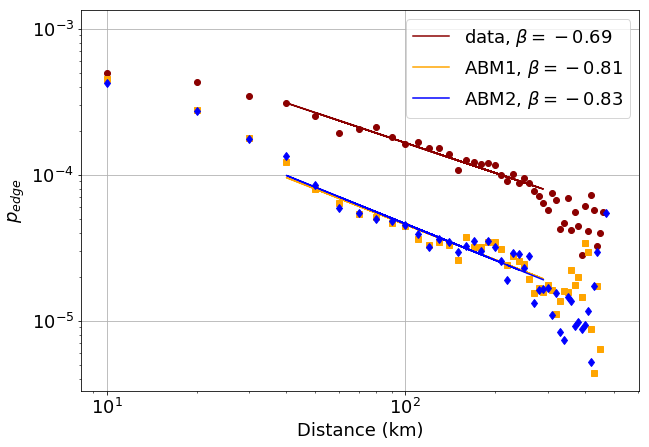

In [62]:
# gravity plots of selected categories
plt.figure(figsize=(10,7))

for col,marker,line,color in zip(gravity_res.keys(),['o','s','d'],['-','-','-'],['darkred','orange','blue']):
    res = {k: gravity_res[col][k][1] / (gravity_res[col][k][0] + gravity_res[col][k][1]) for k in gravity_res[col]}
    x = np.array([k for k in res])
    y = np.array([res[k] for k in res])
    def f(x,a,b):
        return a*x+b
    m = (x>30)&(x<300)
    p,pcov = curve_fit(f,np.log(x)[m],np.log(y)[m])
    plt.plot(x,y,marker,color=color)
    if col=="month":
        label="data"
    else:
        label=col
    plt.plot(x[m],np.exp(f(np.log(x)[m],*p)),line,color=color,label=label+r", $\beta=%.2f$" % p[0])
plt.loglog()
plt.legend()
plt.grid()
plt.xlabel("Distance (km)")
plt.ylabel(r"$p_{edge}$")
plt.savefig("gravity_plots.png",density=300)